In [16]:
from google.colab import drive
drive.mount('/content/drive')
import IPython

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Credit to Dr. Trevor Harris (STAT 335) and Dr. Bobak Mortazavi (CSCE 421)

# **Simple Linear Regression**

A linear regression model using the predictor $X_i$ is : 

$$ f(X_i) = \beta_0 + \beta_1 X_i $$

We assume that the deterministic relationship is just a line
 - $X$ is __continuous__
 - $f(X)$ is **continuous**
 - $\beta_0$ is the __intercept__
 - $\beta_1$ is the __slope__

We will use $f(X_i)$ to predict $Y_i$ for each $i = 1,...,n$. So, the model for $Y$ is: 

$$Y = f(X) + \epsilon = \beta_0 + \beta_1 X + \epsilon $$.


$\epsilon_i = Y_i - f(X_i)$ = Residual Error for $i^{th}$ observation.


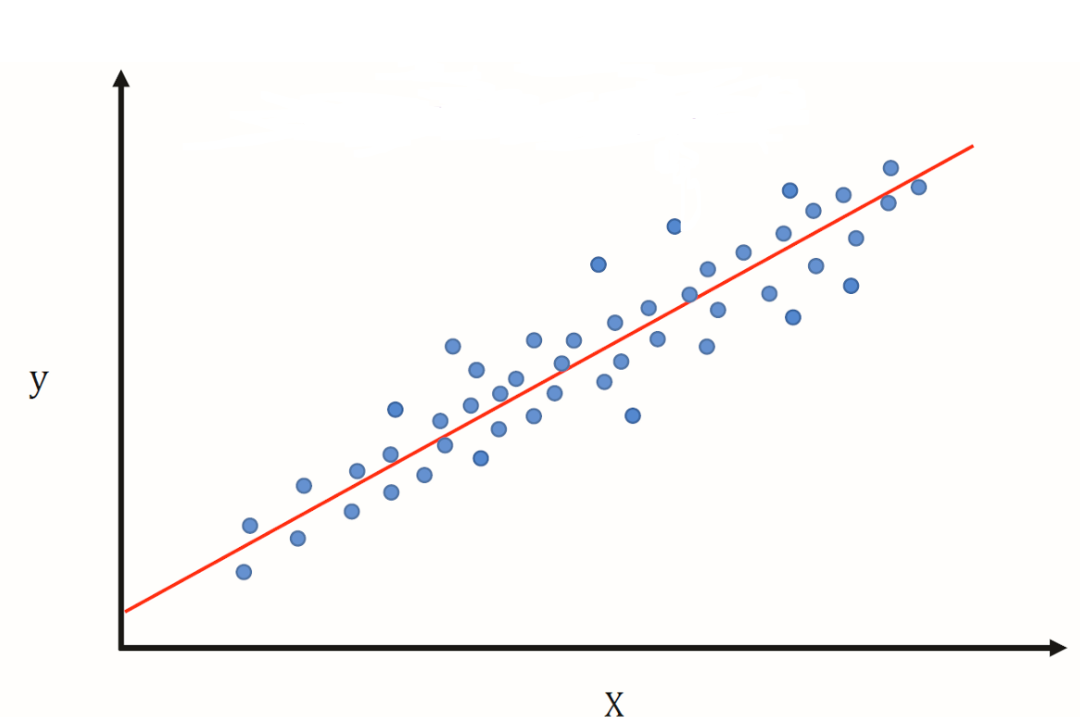

In [17]:
IPython.display.Image('/content/drive/Shareddrives/Aggie Data Science Club/Workshops/2023-02-21/simple_linreg.PNG', width = 600)

# **Multiple Linear Regression**

Lets extend the linear regression case to the case where we have $p$ variables that we want to use to predict $Y$
 - More information is better!

So the model for $Y$ is

$$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \ldots + \beta_p X_p + \epsilon $$

This is simply a linear regression model with more than one predictor. Visually, it becomes a multidimensional graph, but there are still inputs and an output.

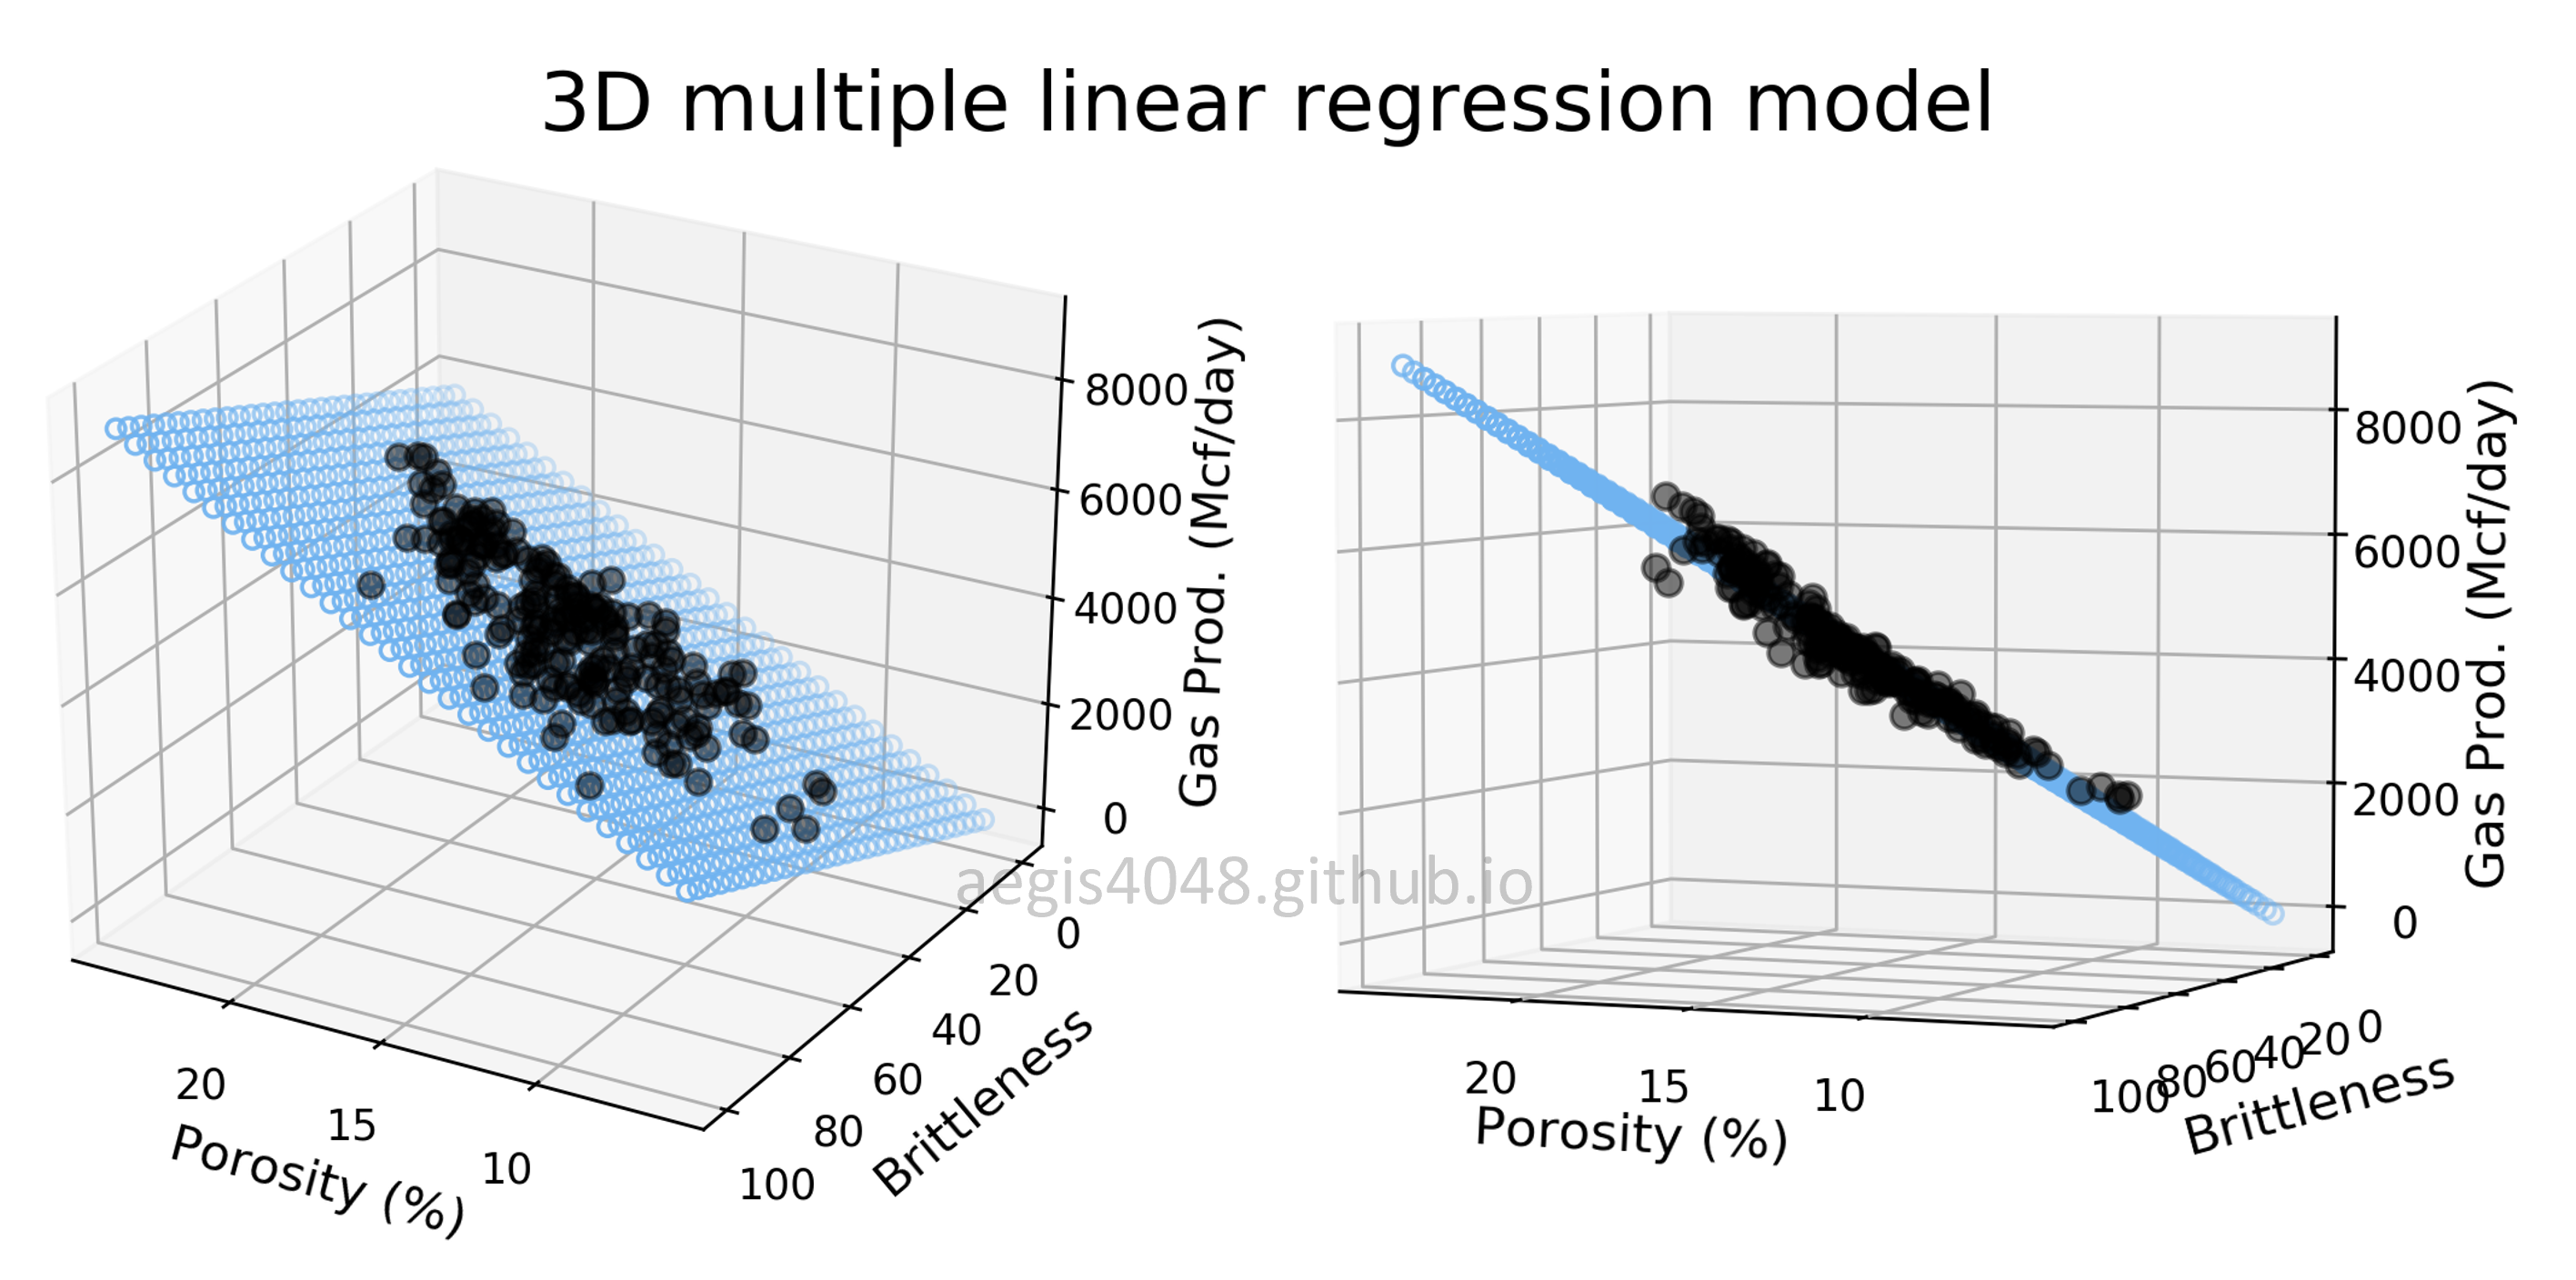

In [18]:
IPython.display.Image('/content/drive/Shareddrives/Aggie Data Science Club/Workshops/2023-02-21/multiple_linreg.png', width = 600)

# **Loss Functions**

Let's say we have a simple linear regression with one feature and one label $f(X_i) = \beta_0 + \beta_1 X_i$. **How can we evaluate how well the model is doing?** 

The answer is a **loss function**: a function that compares the observations to the actual values with residuals. The simplest loss function is the summation of all the residuals for each observation.

$$ SR = \sum_{i=1}^{N}{y_i-\hat{y}_i} $$

The issue is that residuals can be positive and negative, so we will instead use **sum of squared residuals (SSR)**. We can also do absolute value, but this makes it hard to differentiate.

$$ SSR = \sum_{i=1}^{N}{(y_i-\hat{y}_i)^2} $$

Another variation that is better in certain situations is **mean square error (MSE)**, which is simply the average residual value.

$$ MSE = \frac{1}{n}\sum_{i=1}^{N}{(y_i-\hat{y}_i)^2} $$

Once we have chosen a loss function for a given model, the optimization process will be identical regardless of the type of model. We want to minimize the loss function, which is why the loss function needs to be differentiable. For linear regression, there are two approaches.

* **Least squares regression**: formula for $\beta_0$ and $\beta_1$ based on partial derivatives, only works for linear regression
* **Gradient descent**: iteratively hone in on the global minimum through trial and error, **works for any type of model**


## Titanic Dataset

Even though regression is not actually the ideal algorithm for this dataset, we will learn about the strengths and weaknesses that will give motivation for other alternatives.

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

In [20]:
data = pd.read_csv('/content/drive/Shareddrives/Aggie Data Science Club/Workshops/2023-02-21/titanic.csv')

In [21]:
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [22]:
df = data
df = data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)
df = df.dropna()
df.shape

(712, 8)

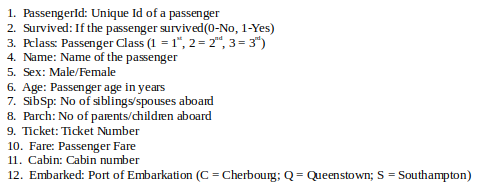

In [23]:
IPython.display.Image('/content/drive/Shareddrives/Aggie Data Science Club/Workshops/2022-11-1 Workshop/titanic_attributes.png', width = 600)

## Quantitative Variables

Completely numerical with no categorical distinctions. Can be **discrete or continuous** based on the types of values the variable can have (e.g. whole numbers vs rational).

* PassengerId (irrelevant)
* Age
* SibSp
* Parch
* Ticket (debatable but irrelevant)
* Fare
* Cabin (irrelevant because no spatial meaning given, every single cabin will be different)

In [24]:
x_quant = df.loc[:, ["Age", "SibSp", "Parch", "Fare"]]

## Qualitative or Categorical Variables

Categorical distinctions. Number of categories is usually significantly smaller than the number of observations (otherwise, can be quantitative). Can be **nominal or ordinal**. Nominal variables have no particular order (e.g. color), while ordinal variables have a natural/intuitive order (e.g. ranking).

* Survived (nominal but does not matter since binary)
* Pclass (ordinal)
* Name (nominal but irrelevant)
* Sex (nominal)
* Embarked (nominal)

In [25]:
# look at category counts for each attribute to verify

df["Pclass"].value_counts()

3    355
1    184
2    173
Name: Pclass, dtype: int64

Categorical variables oftentimes need to be encoded into numerical values that can be piped into ML algorithms. **Ordinal variables** have an intuitive order, so if they are given numerically, they can usually be kept intact. On the other hand, **nominal variables** need to be encoded.

Many methods of encoding, but one method is **one-hot encoding**.

* For each of the $k$ categories, there are $k$ dummy features (or columns) created
* Mark each entry as 0 or 1 based on whether it belongs to the given category

A better method is **dummy encoding**.

* Same as one-hot encoding except there are $k-1$ new dummy features (dropped one category)
* Dropped category serves as the baseline, other categories measure difference from baseline

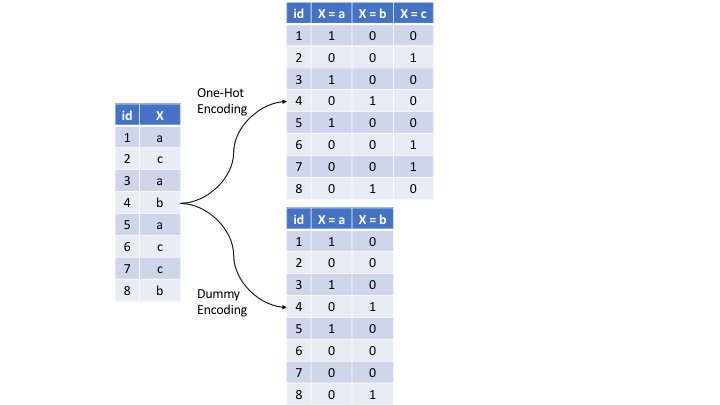

In [26]:
IPython.display.Image('/content/drive/Shareddrives/Aggie Data Science Club/Workshops/2023-02-21/encoding.png', width = 500)

In [27]:
from sklearn.preprocessing import OneHotEncoder

x_nom = df.loc[:,["Sex", "Embarked"]]

enc = OneHotEncoder()
enc.fit(x_nom)

x_cat = enc.transform(x_nom).toarray()

print(x_cat.shape)
print(["{}: {} categories".format(col, len(df[col].value_counts())) for col in x_nom.columns])

x_cat

(712, 5)
['Sex: 2 categories', 'Embarked: 3 categories']


array([[0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0.]])

# **Linear Regression**

Sci-kit learn abstracts much of the inner mathematics (minimizing loss functions, error optimization, etc.) These details are important to understand, but usually better to rely on built-in functions.

First, identify the response/independent variable of interest.

In [28]:
# predict whether people survived

y = df.loc[:, ["Survived"]]

Now, accumulate all the predictors/covariates/dependent variables of interest. Correctly process quantitative and qualitative variables. Then, concatenate everything into a stack of variables.

In [29]:
# best combo: ["Age", "SibSp"], ["Pclass"], ["Sex"]

# select quantitative features
x_quant = df.loc[:, ["Age", "SibSp"]]

# ordinal (already encoded)
x_ord = df.loc[:, ["Pclass"]]


# encode categorical features
x_nom = df.loc[:,["Sex"]]

enc = OneHotEncoder()
enc.fit(x_nom)

x_cat = enc.transform(x_nom).toarray()


# create interaction features (need to use np arrays for dimensions)
x_int_fare_pclass = np.array(df.loc[:, ["Fare"]]) * np.array(df.loc[:, ["Pclass"]])

# concatenate all features into a single covariate array x
x = np.hstack([x_quant, x_ord, x_cat])

**Train-Test Split** If the model is built on the *entire* dataset, the model will fit extremely well with the given dataset, minimizing the error. However, this model would not be **generalizable** to other sets of data, resulting in **overfitting**. Therefore, we split the entire dataset into training and testing sets. We will train the model on the training data, and then evaluate the fit with the testing data.

In [30]:
# splits into training and testing for each of x and y based on test_size
# from sklearn.model_selection --> train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

Fit the model and make predictions. yhat indicates predictions based on the model.

In [31]:
from sklearn.linear_model import LinearRegression

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

lm = LinearRegression()
lm.fit(x_train, y_train)
yhat_train = lm.predict(x_train)
yhat_test = lm.predict(x_test)

# **Judging the Model with MSE and $R^2$**

Certain numerical metrics can be used to gauge the correctness, accuracy, and validity of a model.

**MSE, or mean square error,** measures the average residual between expected and actual values. We can calculate this manually based on the values we predicted.

**$R^2$, or coefficient of determination** measures the amount of variation in the predictor explained by the model. sklearn provides a function to calculate this value for a model.

The goal is to **minimize MSE and maximize $R^2$** for the testing dataset, which means we have an accurate model that effectively predicts the independent variable. We can also compare the metrics from training to testing to see whether the model generalizes well.

In [32]:
print("Train")
print('MSE -', np.mean((y_train - yhat_train)**2))
print('R2 - ', lm.score(x_train, y_train))

print()

print("Test")
print('MSE -', np.mean((y_test - yhat_test)**2))
print('R2 - ', lm.score(x_test, y_test))

Train
MSE - 0.13358501415526558
R2 -  0.44160668934205205

Test
MSE - 0.17095865520879858
R2 -  0.29878255095767237


# **Hypothesis Testing for Model Correctness**


A more in-depth analysis of the effects of individual variables would be helpful for guiding us when modifying the model.

The following regression results table contains a lot of information, but the most important is the second section listing attributes of each term in the regression equation $\hat{y} = \beta_0 + \beta_1 * x_1 + ... + \beta_p * x_p$.

Each term relates to a predictor that we passed in when fitting the model (same order as stack). The most important columns are **P>|t|** and **[0.025 0.975]**.

**P>|t|** describes the p-value that the null hypothesis $H_{0_i}$ is true, where $H_{0_i}: \beta_i = 0$. This means that specific predictor is not significant and does not contribute to the response variable. Therefore, if the p-value is low, we can reject the null and claim that the predictor is significant.

**[0.025 0.975]** is very similar. If 0 is NOT in the 95% confidence interval, then we can reject $H_{0_i}$ and claim that the given predictor is significant.

**However, this type of parameter tuning can be misleading since significance of a given variable can depend on the set of variables.**

In [33]:
import statsmodels.api as sm

x_train2 = sm.add_constant(x_train)
est = sm.OLS(y_train, x_train2) 
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     93.32
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           2.00e-58
Time:                        23:05:08   Log-Likelihood:                -196.73
No. Observations:                 477   AIC:                             403.5
Df Residuals:                     472   BIC:                             424.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7886      0.053     15.002      0.0

# **Introducing Classification**




Regression is for predicting continuous values, but in many cases, we need to predict a categorical value, which requires **classification**. 

For our Titanic dataset, binary classification makes more sense since the *Survived* label is actually a categorical variable, even though it is given as 0-1.

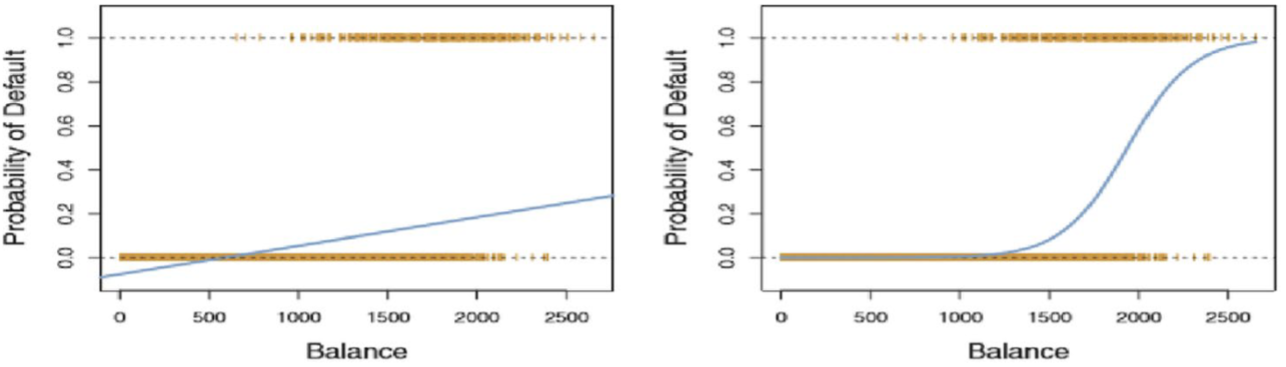

In [34]:
IPython.display.Image('/content/drive/Shareddrives/Aggie Data Science Club/Workshops/2023-02-21/lin_log.PNG', width = 1000)

The graphs above show why we need to switch our approach for classification. In the case of binary classification, a polynomial line from linear regression does not effectively track the separation between 0s and 1s. Essentially, we need to find the **decision boundary** at which we can confidently classify a sample as 0 or 1.


Ideally, we would have a steep **step function** that switches from 0 to 1 instantly with a corner. However, this function would not be differentiable, which would prevent us from using *gradient descent* to optimize. 


Therefore, we approximate the step function in *logistic regression* using a smoother **sigmoid function**, which separates observations with a level of confidence.

There are other forms of approximating step functions, which form the basis of other models. Some examples are shown below.

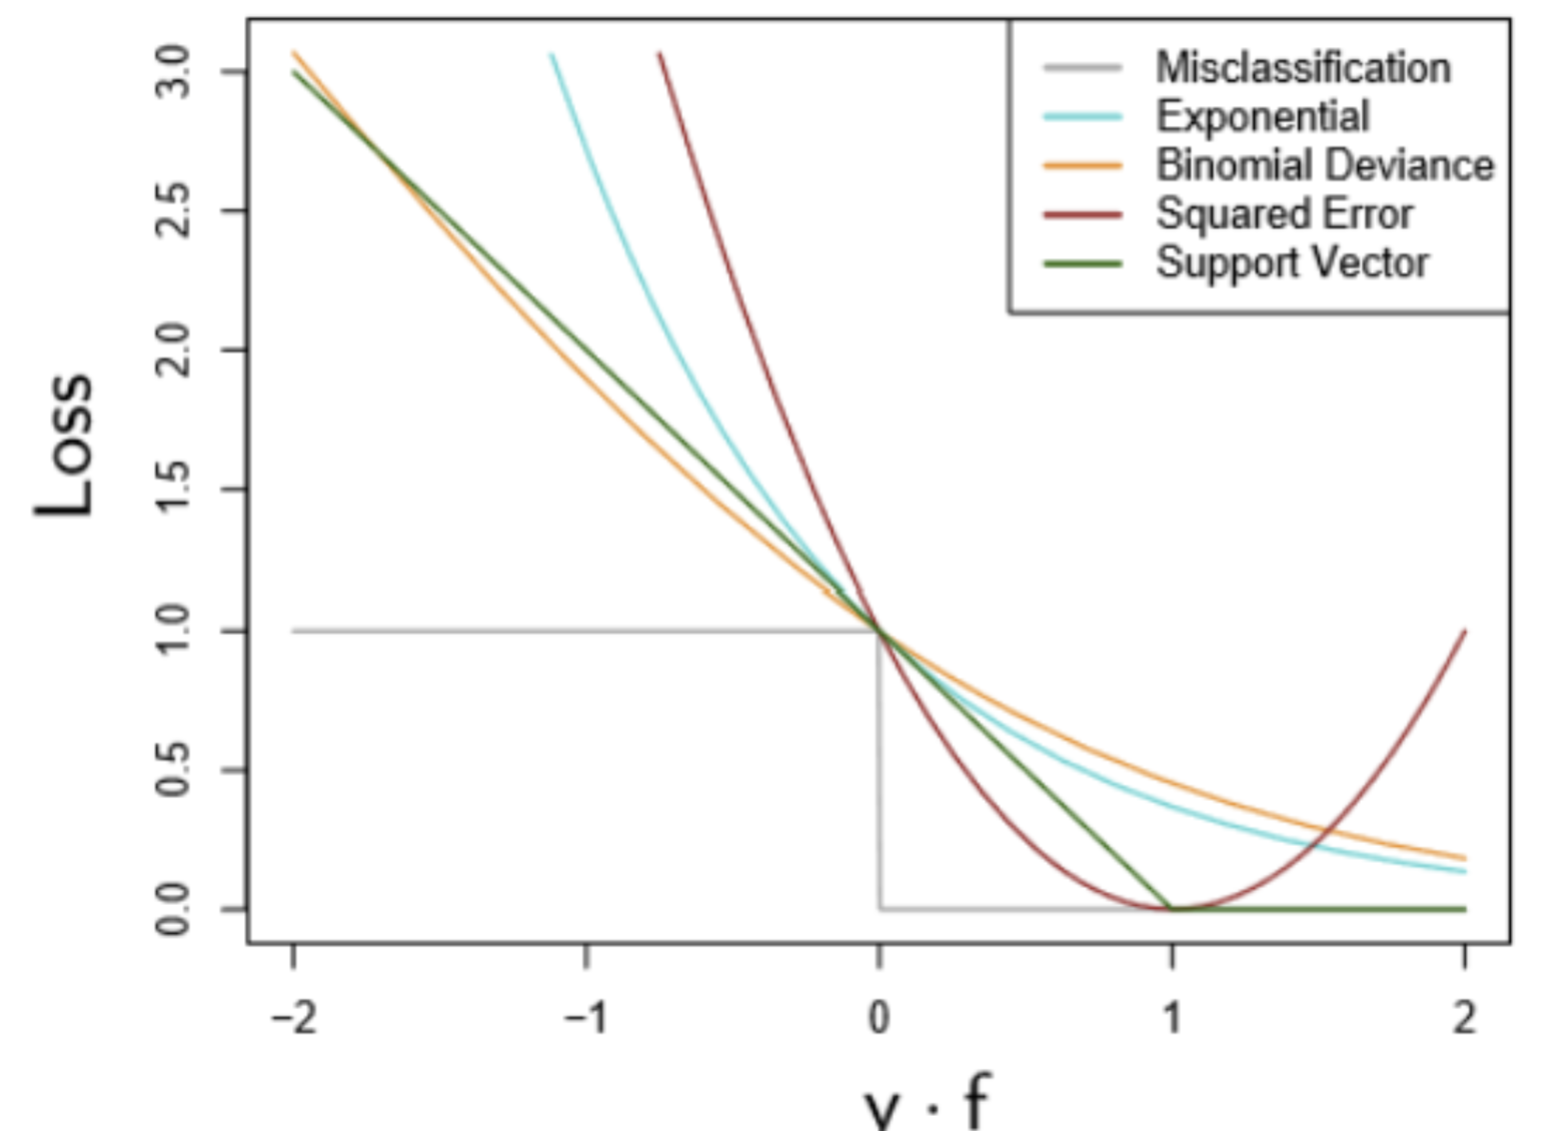

In [35]:
IPython.display.Image('/content/drive/Shareddrives/Aggie Data Science Club/Workshops/2023-02-21/classification_approx.PNG', width = 500)

There are two types of classification models: **discriminative** and **generative**.

* Discriminative models ask the question "How are they different?"
* Generative models ask the question "Why are they the way they are?"

An example is the lion and monkey identification problem. Bob sees differences, while Joe can remember individual features. They tour the zoo and see a lion and monkey.  Afterwards, the zookeeper asks each of them to draw a lion, and they are both correct by different methods. Bob discriminates between the animals, and Joe generates images of the animals.

**All of our models today are discriminative because they rely on decision boundaries as explained above.**

# **Logistic Regression**

The sigmoid function is optimized with a level of confidence under the hood by scikit-learn.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [37]:
df.head()

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S

First, we prepare the features. This time, we use regular one-hot encoding.

In [38]:
dummies = ['Embarked', 'Sex']
dummy_data = pd.get_dummies(df[dummies])

df_ready = pd.concat([df, dummy_data], axis = 1)
df_ready.drop(dummies, axis=1, inplace=True)

In [39]:
df_ready.head()

Survived  Pclass   Age  SibSp  Parch     Fare  Embarked_C  Embarked_Q  \
0         0       3  22.0      1      0   7.2500           0           0   
1         1       1  38.0      1      0  71.2833           1           0   
2         1       3  26.0      0      0   7.9250           0           0   
3         1       1  35.0      1      0  53.1000           0           0   
4         0       3  35.0      0      0   8.0500           0           0   

   Embarked_S  Sex_female  Sex_male  
0           1           0         1  
1           0           1         0  
2           1           1         0  
3           1           1         0  
4           1           0         1

In [40]:
X = df_ready.drop('Survived', axis = 1)
y = df_ready['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [41]:
log_reg = LogisticRegression(penalty='l2') #Penalty/regularization is optional
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Measuring Performance

$accuracy = \frac{correct}{total} = \frac{TP+TN}{TP+FN+TN+FP}$

$precision = $ how many of **predicted** positives were correct $ = \frac{TP}{TP+FP}$

$recall = $ how many **actual** positives were identified $ = \frac{TP}{TP+FN}$

$F1 = $ combines precision and recall $ = \frac{TP}{TP+\frac{1}{2}(FP+FN)}$

In [42]:
accuracy_score(y_pred, y_test)

0.7622377622377622

In [43]:
# assumes threshold of 50%
confusion_matrix(y_pred, y_test)

array([[76, 15],
       [19, 33]])

69 true negatives, 19 false negatives, 13 false positives, 42 true positives

In [44]:
report = classification_report(y_pred, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        91
           1       0.69      0.63      0.66        52

    accuracy                           0.76       143
   macro avg       0.74      0.73      0.74       143
weighted avg       0.76      0.76      0.76       143



# **K-Nearest Neighbor**

Instead of using complex math to optimize a loss function, K-Nearest Neighbor classifies observations by simply looking at the closest neighbors on a graphical plane. By increasing the number of neighbors, we can generalize the model to prevent overfitting to outliers.

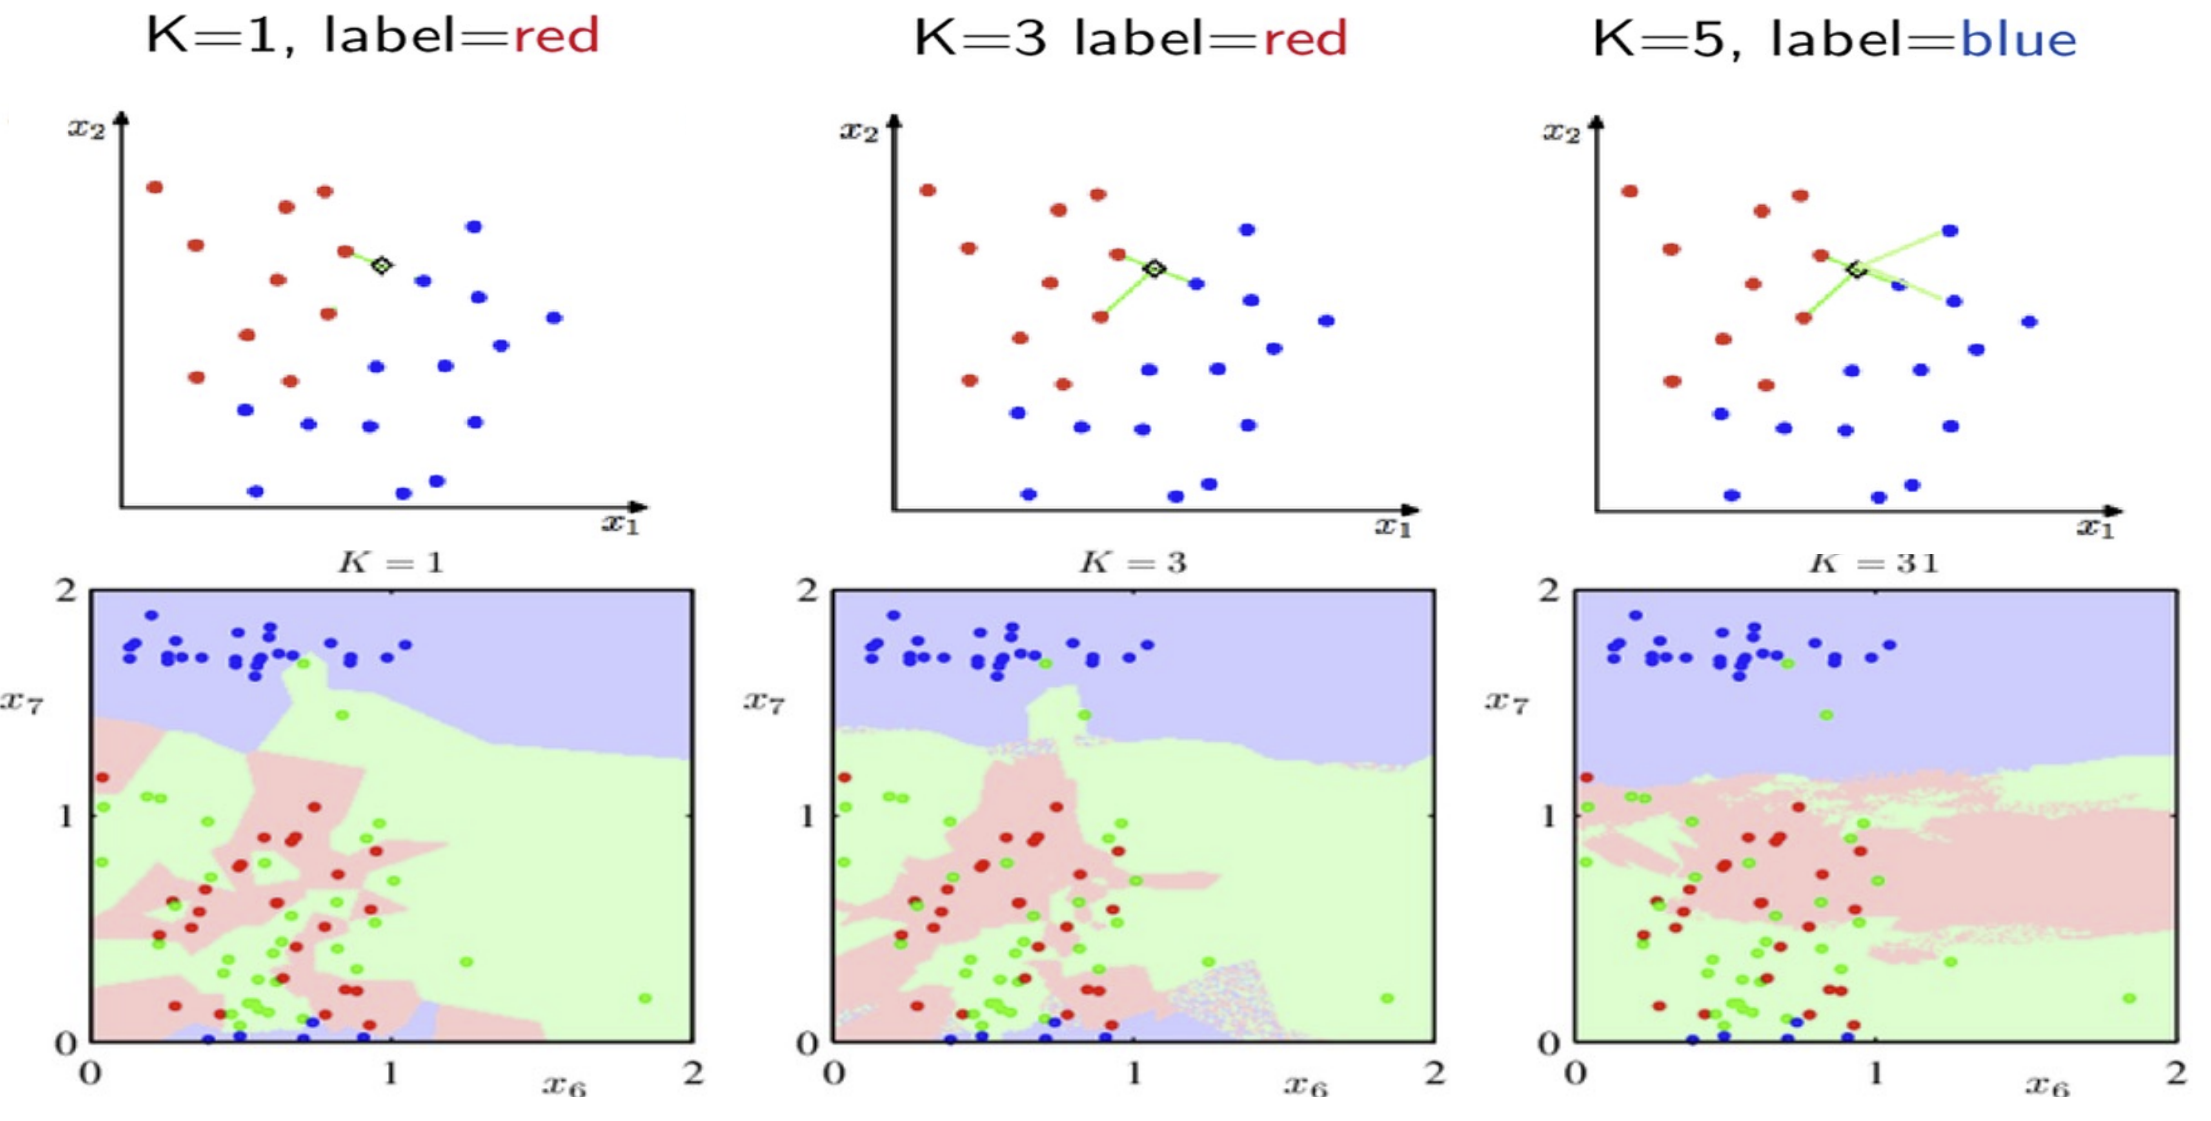

In [45]:
IPython.display.Image('/content/drive/Shareddrives/Aggie Data Science Club/Workshops/2023-02-21/knn.png', width = 600)

In [46]:
#ignore these next three
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

neigh_pred = neigh.predict(X_test)

neigh_matrix = confusion_matrix(y_test,neigh_pred)

In [47]:
print(classification_report(y_test,neigh_pred))
print(neigh_matrix)

              precision    recall  f1-score   support

           0       0.75      0.74      0.74        95
           1       0.50      0.52      0.51        48

    accuracy                           0.66       143
   macro avg       0.63      0.63      0.63       143
weighted avg       0.67      0.66      0.67       143

[[70 25]
 [23 25]]


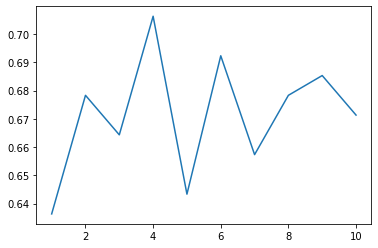

In [58]:
import matplotlib.pyplot as plt

neighbor_min = 1
neighbor_max = 10

scores = []

# affect of k on the accuracy
for k in range(neighbor_min, neighbor_max+1):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  scores.append(knn.score(X_test, y_test))

plt.plot(range(neighbor_min, neighbor_max+1), scores)
plt.show()


# **Decision Tree and Random Forest**

Instead of approximating the step function, we can instead use simple "yes or no" questions to *discriminate* observations into groups. By repeating this process, we can place observations into buckets based on their attributes. These choices can be visualized in a **decision tree**.

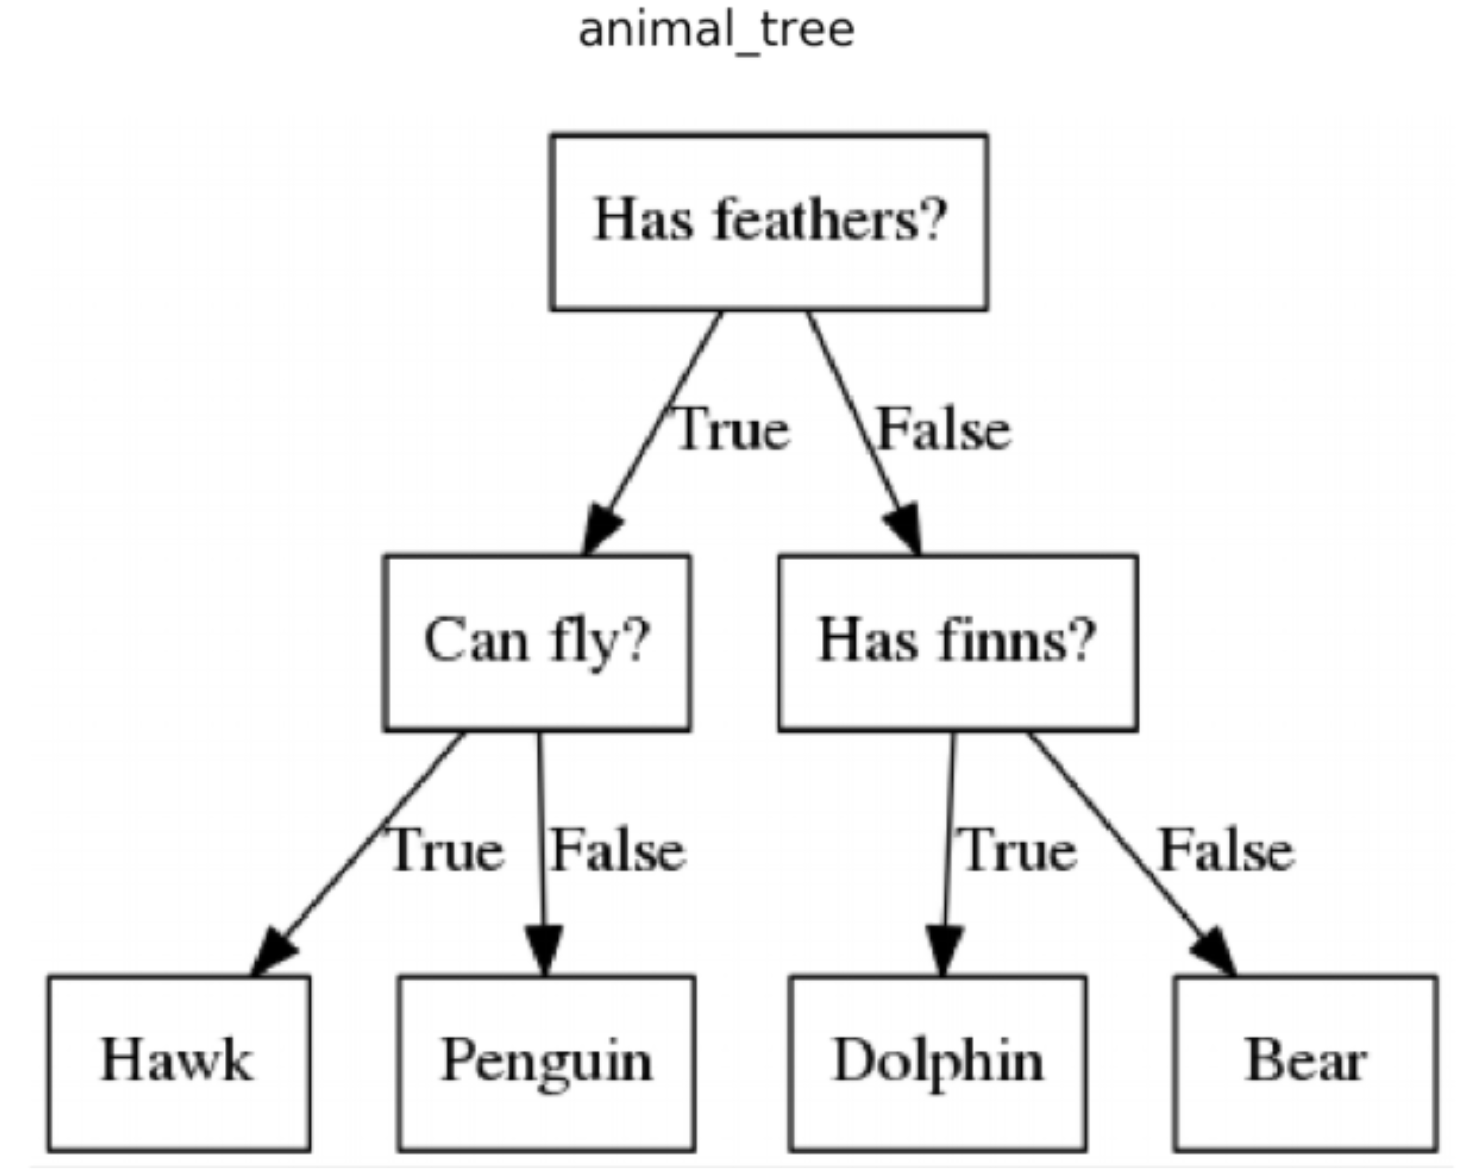

In [48]:
IPython.display.Image('/content/drive/Shareddrives/Aggie Data Science Club/Workshops/2023-02-21/decision_tree_example.PNG', width = 300)

The model design is much simpler for a decision tree, since there is no gradient descent nor loss function needed. However, we still need to optimize in some way. There are multiple ways of optimizing:
* Classification error rate
* Gini index
* Shannon cross entropy

These have complicated mathematical derivations, but the overall goal is **maximize the purity of each node**. In other words, the node discriminates well between the input observations. As shown below, *Patrons* does a better job of discriminating at a given level than *Type* does, which means *Patrons* is a more pure factor than *Type*.

Ultimately, model tuning requires a balance of splitting and pruning to build an accurate yet generalizable model. 

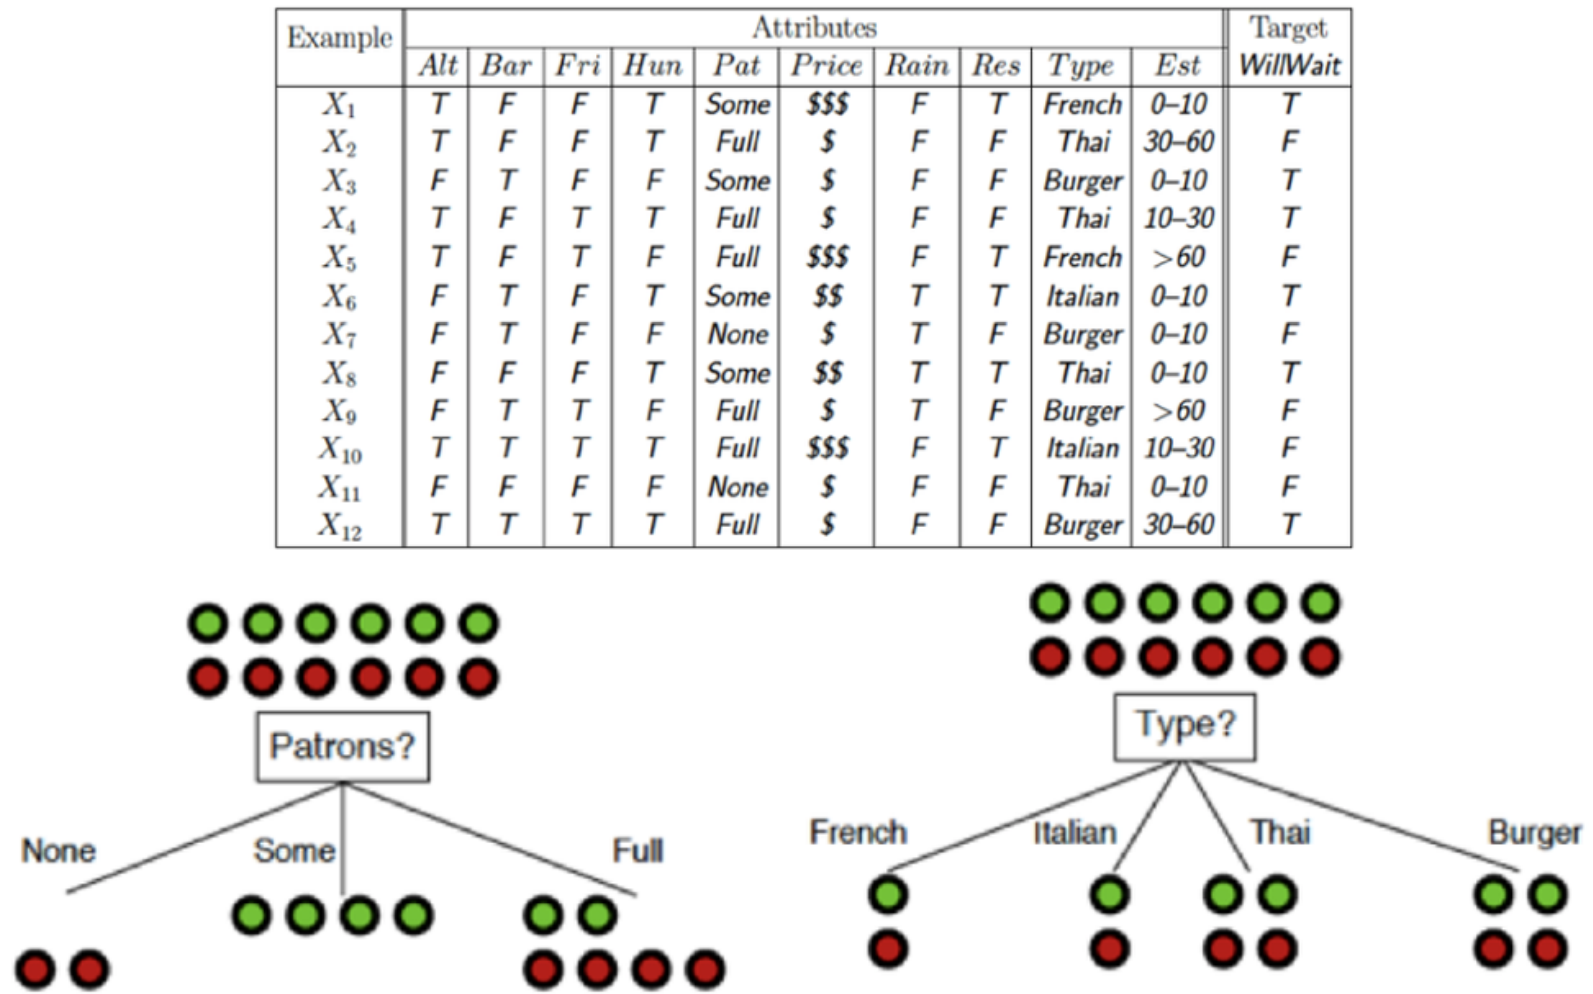

In [49]:
IPython.display.Image('/content/drive/Shareddrives/Aggie Data Science Club/Workshops/2023-02-21/dt_purity.PNG', width = 500)

As you might be able to tell, there can be many different permutations of a decision tree based on the selected variables and the depth of those variables. It would be best to try out these different options to make a more informed model. There are several methods to try these permutations, but the most popular is **random forests**.

Essentially, a bunch of different decision trees are created, each with different sets of decision nodes. When classifying an observation, the input data is piped into all of the decision trees and **the consensus label is the final output**. Majority vote is generally used for classification, but random forests can also be applied in regression by taking the average of the predictions.

In [50]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=1000)
rf_model.fit(X_train,y_train)

rf_pred = rf_model.predict(X_test)

rf_matrix = confusion_matrix(y_test,rf_pred)

In [51]:
print(classification_report(y_test,rf_pred))
print(rf_matrix)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82        95
           1       0.65      0.62      0.64        48

    accuracy                           0.76       143
   macro avg       0.73      0.73      0.73       143
weighted avg       0.76      0.76      0.76       143

[[79 16]
 [18 30]]


# Drop-in models that we will not be explaining

In [52]:
from sklearn.svm import SVC

clf_poly = SVC(kernel="poly")
clf_poly.fit(X_train, y_train)

clf_lin = SVC(kernel="linear")
clf_lin.fit(X_train, y_train)

clf_rbf = SVC(kernel="rbf")
clf_rbf.fit(X_train, y_train)

SVC()

In [53]:
poly_pred = clf_poly.predict(X_test)
lin_pred = clf_lin.predict(X_test)
rbf_pred = clf_rbf.predict(X_test)

In [54]:
poly_report = classification_report(y_test,poly_pred)
poly_matrix = confusion_matrix(y_test,poly_pred)
print(poly_report)
print(poly_matrix)

              precision    recall  f1-score   support

           0       0.69      0.99      0.81        95
           1       0.86      0.12      0.22        48

    accuracy                           0.70       143
   macro avg       0.77      0.56      0.52       143
weighted avg       0.75      0.70      0.61       143

[[94  1]
 [42  6]]


In [55]:
lin_report = classification_report(y_test,lin_pred)
lin_matrix = confusion_matrix(y_test,lin_pred)
print(lin_report)
print(lin_matrix)

              precision    recall  f1-score   support

           0       0.86      0.81      0.83        95
           1       0.66      0.73      0.69        48

    accuracy                           0.78       143
   macro avg       0.76      0.77      0.76       143
weighted avg       0.79      0.78      0.79       143

[[77 18]
 [13 35]]


In [56]:
rbf_report = classification_report(y_test,rbf_pred)
rbf_matrix = confusion_matrix(y_test,rbf_pred)
print(rbf_report)
print(rbf_matrix)

              precision    recall  f1-score   support

           0       0.75      0.80      0.77        95
           1       0.54      0.46      0.49        48

    accuracy                           0.69       143
   macro avg       0.64      0.63      0.63       143
weighted avg       0.68      0.69      0.68       143

[[76 19]
 [26 22]]
